In [2]:
#Imports
import PySAM
import PV_ICE
import pandas as pd
import numpy as np
import json
import os
from PySAM import Pvsamv1 as pv
from PySAM import Pvwattsv8 as pvwatts
from PySAM import Cashloan as res
from PySAM import Grid as grid
from PySAM import Utilityrate5 as ur
import PySAM.Pvsamv1Tools as pvtools
import PySAM.ResourceTools as tools

In [3]:
# This information helps with debugging and getting support :)
import sys, platform
print("Working on a ", platform.system(), platform.release())
print("Python version ", sys.version)
print("Pandas version ", pd.__version__)
print("PySAM version ", PySAM.__version__)
print("PV_ICE version ", PV_ICE.__version__)

Working on a  Windows 10
Python version  3.11.7 | packaged by Anaconda, Inc. | (main, Dec 15 2023, 18:05:47) [MSC v.1916 64 bit (AMD64)]
Pandas version  2.1.4
PySAM version  7.0.0
PV_ICE version  0.4.4.dev2+g378a012.d20250320


### Residential Repowering Scenario
-Original system operates for X years

-Need for roof repair, other reason to take panels off roof in year X

-Calculate financials (net present value, payback period) for reinstalling existing panels vs. repowering with new modules


In [13]:
#Step 1. Set up original system
#Read in PySAM json
# create a new instance of the Pvwattsv8 module
pv_model = pvwatts.default("PVWattsResidential")
fin_model = res.from_existing(pv_model)
#Alternatively, use PVWatts
#pv_model = PySAM.Pvwattsv8.new()
grid_model = grid.from_existing(pv_model)
ur_model = ur.from_existing(pv_model)

#User: input json files from SAM
# json_file_folder = "Repower_example"
# json_files = next(os.walk(json_file_folder))[2]
# json_files.sort()
# get the inputs from the JSON file
for json_file in os.listdir('PBL 3_Data'):
    with open( 'PBL 3_Data/' + json_file, 'r') as f:
            pv_inputs = json.load( f )
    
    # iterate through the input key-value pairs and set the module inputs
    for k, v in pv_inputs.items():
        if k != 'number_inputs':
            try:
                pv_model.value(k, v)
            except:
                try:
                    ur_model.value(k, v)
                except:
                    try:
                        grid_model.value(k, v)
                    except:
                        try:
                            fin_model.value(k, v)
                        except:
                            print("Variable not found in modules:" + str(k))

fin_model = res.from_existing(pv_model)
#Alternatively, use PVWatts
#pv_model = PySAM.Pvwattsv8.new()
grid_model = res.from_existing(pv_model)
ur_model = ur.from_existing(pv_model)


Variable not found in modules:en_belpe
Variable not found in modules:floor_area
Variable not found in modules:Stories
Variable not found in modules:YrBuilt
Variable not found in modules:Retrofits
Variable not found in modules:Occupants
Variable not found in modules:Occ_Schedule
Variable not found in modules:THeat
Variable not found in modules:TCool
Variable not found in modules:THeatSB
Variable not found in modules:TCoolSB
Variable not found in modules:T_Sched
Variable not found in modules:en_heat
Variable not found in modules:en_cool
Variable not found in modules:en_fridge
Variable not found in modules:en_range
Variable not found in modules:en_dish
Variable not found in modules:en_wash
Variable not found in modules:en_dry
Variable not found in modules:en_mels
Variable not found in modules:Monthly_util


In [14]:
#Step 2. Download resource data
#Read in weather data from SAM, or use NSRDB downloads in SAM format, or use dictionary of solar data
#A. You already have a file
weather_file = "data/CO_weather_data.csv"
pv_model.SolarResource.solar_resource_file = weather_file

#B. solar_resource_data
# weather_data = PySAM.ResourceTools.SAM_CSV_to_solar_data(weather_file)
# solar_resource_data = {
#         'tz': tz, # timezone
#         'elev': elev, # elevation
#         'lat': lat, # latitude
#         'lon': lon, # longitude
#         'year': tuple(weather_data[0]), # year
#         'month': tuple(weather_data[1]), # month
#         'day': tuple(weather_data[2]), # day
#         'hour': tuple(weather_data[3]), # hour
#         'minute': tuple(weather_data[4]), # minute
#         'dn': tuple(weather_data[5]), # direct normal irradiance
#         'df': tuple(weather_data[6]), # diffuse irradiance
#         'gh': tuple(weather_data[7]), # global horizontal irradiance
#         'wspd': tuple(weather_data[8]), # windspeed
#         'tdry': tuple(weather_data[9]) # dry bulb temperature
#         }
# pv_model.unassign("solar_resource_file")
# pv_model.SolarResource.solar_resource_data = solar_resource_data

#C. Download from NSRDB
# 
# --- Initialize Solar Resource Fetcher with minimum parameters ---
# See function documentation for full parameter list

#import geocoder

# replace with key and email address from https://developer.nrel.gov/signup/
sam_api_key = os.environ.get('NREL_API_KEY')
sam_email = os.environ.get('NREL_API_EMAIL')
# sam_api_key = nrel_developer_key
# sam_email = sam@email.com
geocode_api_key = ''  # optional, may be required for geocoder

# --- Location Coordinates ---

# Set geocode to True to use geocoding service API
geocode = False
if geocode:
    # See https://geocoder.readthedocs.io/ for different geocoding services
    g = geocoder.bing('golden, co', key=geocode_api_key)
    lon = g.latlng[1]
    lat = g.latlng[0]
else:
    lon = -105.22
    lat = 39.75
nsrdbfetcher = tools.FetchResourceFiles(
                tech='solar',
                nrel_api_key=sam_api_key,
                nrel_api_email=sam_email)

# --- List of (lon, lat) tuples or Shapely points ---
lon_lats = [(lon, lat)]
nsrdbfetcher.fetch(lon_lats)

# --- Get resource data file path ---
nsrdb_path_dict = nsrdbfetcher.resource_file_paths_dict
nsrdb_fp = nsrdb_path_dict[lon_lats[0]]
#pv_model.SolarResource.solar_resource_file = nsrdb_fp


Starting data download for solar using 1 thread workers.
Getting list of available NSRDB files for 39.75, -105.22.
Error for 39.75, -105.22: {
  "error": {
    "code": "API_KEY_INVALID",
    "message": "An invalid api_key was supplied. Get one at https://developer.nrel.gov/signup/"
  }
}


### 2nd Life case

In [22]:
#second life - Unknown number of remaining years of life
secondlife = pvwatts.from_existing(pv_model)
secondlife_financial = res.from_existing(fin_model)
grid_model = grid.from_existing(secondlife)
ur_model = ur.from_existing(secondlife_financial)
repower = pvwatts.from_existing(pv_model)
repower_financial = res.from_existing(fin_model)

remaining_years = np.arange(1, 21, 1) #calculate for 1 year of life to 20, modified by user
secondlife_npv = []
secondlife_payback = []
nameplate_loss = 0 #User set degradation panel as nameplate % loss

secondlife.SystemDesign.losses = secondlife.SystemDesign.losses + nameplate_loss 

secondlife_system_capacity = secondlife.SystemDesign.system_capacity * 1000 #Wdc
secondlife_variable_cost = np.arange(0.1, 2.1, 0.1)
secondlife_fixed_cost = 2400 #$

secondlife_df = pd.DataFrame(np.empty((400, 4)), columns=['Cost', 'Lifetime', 'NPV', 'Payback'])


i = 0
#secondlife_financial.SystemCosts.total_installed_cost = secondlife_fixed_cost
for lifetime in remaining_years:
    for cost in secondlife_variable_cost:
        secondlife.Lifetime.analysis_period = lifetime
        grid_model.Lifetime.analysis_period = lifetime
        ur_model.Lifetime.analysis_period = lifetime

        secondlife_df.iloc[i, 0] = cost
        secondlife_df.iloc[i, 1] = lifetime
        
        
        secondlife.execute()
        grid_model.execute()
        ur_model.execute()
        secondlife_financial.FinancialParameters.analysis_period = lifetime
        # secondlife_financial.SystemOutput.degradation = [0]
        secondlife_financial.SystemOutput.gen = secondlife.Outputs.gen
        secondlife_financial.SystemCosts.total_installed_cost = cost * secondlife_system_capacity
        secondlife_financial.execute()
        secondlife_npv.append(secondlife_financial.Outputs.npv) #$
        secondlife_payback.append(secondlife_financial.Outputs.payback) #years

        secondlife_df.iloc[i, 2] = secondlife_financial.Outputs.npv
        secondlife_df.iloc[i, 3] = secondlife_financial.Outputs.payback
        i = i + 1
print(i)


400


### New Build Case

In [25]:
#newbuild case - Known system size, lifetime
newbuild = secondlife
newbuild_financial = res.from_existing(newbuild)
grid_model = grid.from_existing(newbuild_financial)
ur_model = ur.from_existing(newbuild_financial)

new_system_analysis_period = 30 #years
newbuild.Lifetime.analysis_period = new_system_analysis_period
grid_model.Lifetime.analysis_period = new_system_analysis_period
ur_model.Lifetime.analysis_period = new_system_analysis_period

newbuild_cost_per_wdc = 2.76 #$/Wdc
newbuild_cost_flat = 10000 #$
newbuild_npv = 0
newbuild_payback = 0

newbuild.execute()
grid_model.execute()
ur_model.execute()
newbuild_financial.SystemOutput.gen = newbuild.Outputs.gen
newbuild_financial.SystemCosts.total_installed_cost = newbuild_cost_per_wdc * newbuild.SystemDesign.system_capacity * 1000
#ITC 30%, user modify
newbuild_financial.TaxCreditIncentives.itc_fed_percent = [30]
# newbuild_financial.SystemCosts.total_installed_cost = newbuild_cost_flat

newbuild_financial.execute()
newbuild_npv = newbuild_financial.Outputs.npv
newbuild_payback = newbuild_financial.Outputs.payback
print(newbuild_npv)

1676.0354857170641


     Cost  Lifetime          NPV   Payback
0     0.1       1.0   542.313411       NaN
1     0.2       1.0   158.104719       NaN
2     0.3       1.0  -226.103974       NaN
3     0.4       1.0  -610.312666       NaN
4     0.5       1.0  -994.521359       NaN
..    ...       ...          ...       ...
395   1.6      20.0  4342.156865  5.618529
396   1.7      20.0  3957.948173  5.952559
397   1.8      20.0  3573.739480  6.281223
398   1.9      20.0  3189.530788  6.608999
399   2.0      20.0  2805.322095  6.936775

[400 rows x 4 columns]


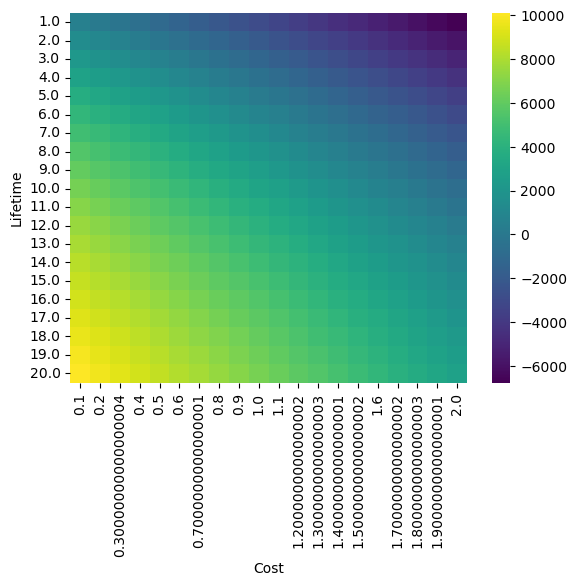

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
print(secondlife_df)
result = secondlife_df.pivot(index='Lifetime', columns='Cost', values='NPV')

sns.heatmap(result, annot=False, fmt="g", cmap='viridis')

#sns.scatterplot(x=data['X'], y=data['Y'], color='red', s=100, ax=ax)

plt.show()

C:\Users\mprillim\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\mprillim\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\mprillim\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\mprillim\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be rem

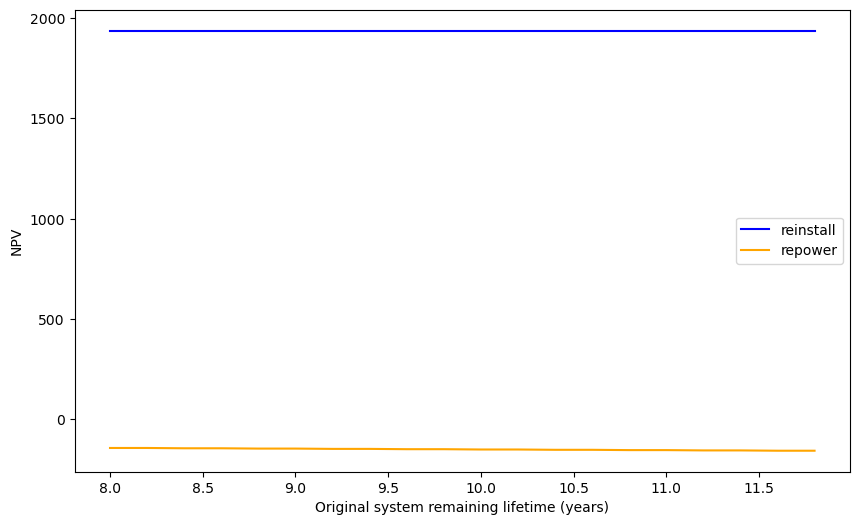

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Sample data
data = pd.DataFrame({
    'x1': capacity_range,
    'y1': repower_npv,
    
})

data['y2'] = reinstall_npv

# Create the main plot
fig, ax1 = plt.subplots(figsize=(10, 6))
sns.lineplot(x='x1', y='y2', data=data, ax=ax1, color='blue', label='reinstall')
ax1.set_xlabel('Original system remaining lifetime (years)')
ax1.set_ylabel('NPV')

# Create the second x-axis
sns.lineplot(x='x1', y='y1', data=data, ax=ax1, color='orange', label='repower')
#ax2.set_xbound(ax1.get_xbound())
#plt.legend(['repower', 'reinstall'])

# Display the plot
plt.show()

In [12]:
#Make decision on repower vs install, run PV_ICE
import PV_ICE as pvice
